In [1]:
%load_ext autoreload
%autoreload 2

#%config IPCompleter.greedy=True

# Rotation curves

First, imports:

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from astropy import units
from pathlib import Path
import os
import astropy.units as u
from astropy.constants import G

import snapshot_obj 
import curve_fit

import importlib

In [81]:
importlib.reload(snapshot_obj)
importlib.reload(curve_fit)

<module 'curve_fit' from '/home/kassiili/Curvaton_Simulations/analysis/curve_fit.py'>

## Get data

In [190]:
# Which halo:
gn = 1; sgn = 0

# Ones that seem alright: 12,0;

# Get LCDM data:
LCDM = snapshot_obj.Snapshot("CDM_V1_LR",127)

In [191]:
# Read halo:
fnum = LCDM.file_of_halo(gn,sgn)
SGNs = LCDM.get_subhalos("SubGroupNumber",fnums=[fnum])
GNs = LCDM.get_subhalos("GroupNumber",fnums=[fnum])

vmax = LCDM.get_subhalos("Vmax",fnums=[fnum]) / 100000 
                                                    # cm/s to km/s 
rmax = LCDM.get_subhalos("VmaxRadius",fnums=[fnum]) \
            * u.cm.to(u.kpc)
COP = LCDM.get_subhalos("CentreOfPotential",fnums=[fnum]) \
            * u.cm.to(u.kpc)

print(np.mean(rmax))
print(np.median(rmax))
print(np.min(rmax),np.max(rmax))
print(rmax.size)
print(np.sum(rmax>20))

# Select halo:
halo_mask = np.logical_and(SGNs == sgn,GNs == gn)
print(halo_mask)
vmax = vmax[halo_mask]
rmax = rmax[halo_mask]
COP = COP[halo_mask]
print(rmax)

23.671940158641757
7.17106838188119
0.9263269285443926 354.28647947401424
64
15
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[354.28647947]


In [199]:
# V1kpc:
SGNs = LCDM.get_subhalos("SubGroupNumber")
GNs = LCDM.get_subhalos( "GroupNumber")
halo_mask = np.logical_and(SGNs == sgn,GNs == gn)
v1kpc = LCDM.get_subhalos("V1kpc") 
v1kpc = v1kpc[halo_mask]

In [206]:
# Read particles:
pts = [1]
SGNs = LCDM.get_particles("SubGroupNumber",part_type=pts)
GNs = LCDM.get_particles("GroupNumber",part_type=pts)
coords = LCDM.get_particles("Coordinates",part_type=pts) * u.cm.to(u.kpc)
mass = LCDM.get_particle_masses(part_type=pts) * u.g.to(u.Msun)

# Select halo:
halo_mask = np.logical_and(SGNs == sgn,GNs == gn)
coords = coords[halo_mask]
mass = mass[halo_mask]

# Periodic wrap coordinates around centre.
with h5py.File(LCDM.part_file,'r') as partf:
    h = partf['link1/Header'].attrs.get('HubbleParam')
    boxs = partf['link1/Header'].attrs.get('BoxSize') * 1000/h 
                                                    # Mpc/h -> kpc
coords = np.mod(coords-COP+0.5*boxs, boxs) + COP-0.5*boxs

In [207]:
# Calculate distance to centre and sort:
r = np.linalg.norm(coords - COP, axis=1)
sorting = np.argsort(r)
r = r[sorting]

cumass = np.cumsum(mass[sorting])

# Begin rotation curve from the 10th particle to reduce noise at the low end of the curve.include only every 10th particle for cleaner curves.
mask = r>0; r=r[mask]; cumass=cumass[mask]
jump = 20
#r = r[jump::jump]
#cumass = cumass[jump::jump]
r = r[jump:]
cumass = cumass[jump:]

# Compute velocity.
myG = G.to(u.km**2 * u.kpc * u.Msun**-1 * u.s**-2).value
v_circ = np.sqrt((myG * cumass) / r)


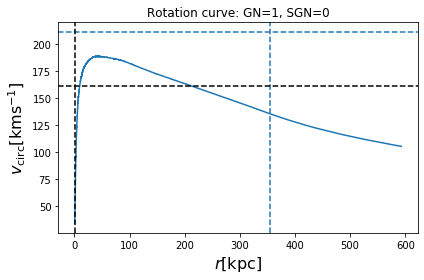

In [208]:
fig, axes = plt.subplots()

# Set axes:
#axes.set_xscale('log')
#axes.set_yscale('log')
#axes.set_xlim(x_down,x_up)
#axes.set_ylim(y_down,y_up)

# Set labels:
axes.set_xlabel('$r[\mathrm{kpc}]$', fontsize=16)
axes.set_ylabel('$v_{\mathrm{circ}}[\mathrm{kms^{-1}}]$', fontsize=16)

# Galaxy text:
axes.set_title('Rotation curve: GN={}, SGN={}'.format(gn,sgn))

axes.plot(r, v_circ)
axes.axhline(vmax,linestyle='dashed')
axes.axvline(rmax,linestyle='dashed')
axes.axhline(v1kpc,linestyle='dashed',c='black')
axes.axvline(1,linestyle='dashed',c='black')
    
#plt.legend()
plt.tight_layout()


# Save figure:
#
#filename = 'cumulDistByVmax_evol_{}.png'.format(galaxy)
#
#home = os.path.dirname(snapshot_obj.__file__)
#path = os.path.join(home,"Figures")
#
## If the directory does not exist, create it
#if not os.path.exists(path):
#    os.makedirs(path)
#plt.savefig(os.path.join(path,filename), dpi=200)